# Image Colourization

In this project, I will build models to perform image colourization. That is, given a greyscale image, I wish to predict the colour at each pixel.

To keep the training time manageable I will use the CIFAR-10 data set, which consists of images of size 32x32 pixels. For most of the questions I will use a subset of the dataset. The data loading script is included with the notebooks, and should download automatically the first time it is loaded.

I will be starting with a convolutional autoencoder and tweaking it along the way to improve our perforamnce. Then as a second part, I will compare the autoencoder approach to conditional generative adversarial networks (cGANs).


# PART A - Autoencoder
In this part we will construct and compare different autoencoder models for the image colourization task.

#### Helper code

Provided are some helper functions for loading and preparing the data.

In [ ]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/a3/
%cd /content/a3


/content/a3


In [ ]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Download CIFAR dataset
m = load_cifar10()

File path: data/cifar-10-batches-py.tar.gz
Extracting file.


## Part 1 Data Preparation

To start off run the above code to load the CIFAR dataset and then work through the following questions/tasks.

### Part (i)
Verify that the dataset has loaded correctly.

In [ ]:
m

((array([[[[ 59,  43,  50, ..., 158, 152, 148],
           [ 16,   0,  18, ..., 123, 119, 122],
           [ 25,  16,  49, ..., 118, 120, 109],
           ...,
           [208, 201, 198, ..., 160,  56,  53],
           [180, 173, 186, ..., 184,  97,  83],
           [177, 168, 179, ..., 216, 151, 123]],
  
          [[ 62,  46,  48, ..., 132, 125, 124],
           [ 20,   0,   8, ...,  88,  83,  87],
           [ 24,   7,  27, ...,  84,  84,  73],
           ...,
           [170, 153, 161, ..., 133,  31,  34],
           [139, 123, 144, ..., 148,  62,  53],
           [144, 129, 142, ..., 184, 118,  92]],
  
          [[ 63,  45,  43, ..., 108, 102, 103],
           [ 20,   0,   0, ...,  55,  50,  57],
           [ 21,   0,   8, ...,  50,  50,  42],
           ...,
           [ 96,  34,  26, ...,  70,   7,  20],
           [ 96,  42,  30, ...,  94,  34,  34],
           [116,  94,  87, ..., 140,  84,  72]]],
  
  
         [[[154, 126, 105, ...,  91,  87,  79],
           [140, 145, 12

In [ ]:
#number of training samples
len(m[0][0])

50000

In [ ]:
#number of testing samples
len(m[1][0])

10000

From the above output, it can be seen that data is loaded correctly. We have 50000 training samples and 10000 testing samples. The data is organized such
that the return output of load_cifar10() is a tuple where the first element is the training set and the second element is the testing set. Both elements
take the form of a tuple where the first element is features and the second element is labels.

### Part (ii)

Provided below is sample code to preprocess the data to select only images of horses, which will help to simplify the goals of the assignment. The function also converts the colour images to greyscale to create our input data.

In [ ]:
# select a single category.
HORSE_CATEGORY = 7

# convert colour images into greyscale
def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


The provided get_batch function creates a dataloader (or function) to batch the samples.

In [ ]:
# dataloader for batching samples

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)


Run the above helper code and call the appropriate fucntion to verify and visualize that we are able to generate different batches of data with the correct class of images (i.e., horses).

Write code to visualize 5 train and test/val images.

In [ ]:
# code to load different batches of horse dataset

print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...


In [ ]:
# shape of data and labels before selection
print(x_train.shape, y_train.shape)

(50000, 3, 32, 32) (50000, 1)


In [ ]:
# shape of training data
print('Training Data: ', train_rgb.shape, train_grey.shape)
# shape of testing data
print('Testing Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (5000, 3, 32, 32) (5000, 1, 32, 32)
Testing Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


Load Batches

In [ ]:
training = get_batch(train_grey, train_rgb, batch_size = 5)
testing = get_batch(test_grey, test_rgb, batch_size = 5)

Write code to visualize 5 train/test images

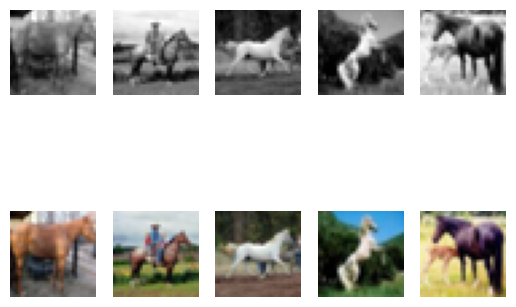

In [ ]:
#5 train images for grey scale and colored
xs, ys = next(training)
xs = torch.from_numpy(xs).float().cuda()
ys = torch.from_numpy(ys).float().cuda()
images, labels = Variable(xs), Variable(ys)

img_grey = images.cpu().detach().numpy()
img_real = labels.cpu().detach().numpy()

#correct image structure
img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])

for j in range(5):
  ax = plt.subplot(2, 5, j + 1)
  ax.imshow(img_grey[j], cmap='gray')
  ax.axis("off")
  ax = plt.subplot(2, 5, j + 1 + 5)
  ax.imshow(img_real[j])
  ax.axis("off")
plt.show()

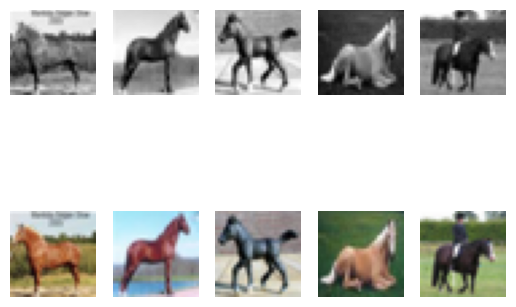

In [ ]:
#5 test images for grey scale and colored
xs, ys = next(testing)
xs = torch.from_numpy(xs).float().cuda()
ys = torch.from_numpy(ys).float().cuda()
images, labels = Variable(xs), Variable(ys)

img_grey = images.cpu().detach().numpy()
img_real = labels.cpu().detach().numpy()

#correct image structure
img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])

for j in range(5):
  ax = plt.subplot(2, 5, j + 1)
  ax.imshow(img_grey[j], cmap='gray')
  ax.axis("off")
  ax = plt.subplot(2, 5, j + 1 + 5)
  ax.imshow(img_real[j])
  ax.axis("off")
plt.show()